In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [5]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42+00:00 to 2019-04-19 19:42:41+00:00
Data columns (total 6 columns):
ip                13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(4)
memory usage: 764.4+ KB


In [7]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44+00:00,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46+00:00,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48+00:00,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [8]:
# cleanup text
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [9]:
# Add Variable - Converting bytes to mb:

df['size_mb'] = [n/1024/1024 for n in df['size']]

In [10]:
df.describe()


,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [11]:
# detect anomaly
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)


# see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,52.87.230.102,2,0.000143
7,70.121.214.34,2,0.000143
8,35.175.171.137,2,0.000143
9,95.31.16.121,1,0.000072
10,35.174.209.2,1,0.000072
11,54.145.52.184,1,0.000072
12,3.88.129.158,1,0.000072
13,34.229.70.250,1,0.000072


22
               ip  ip_count  ip_proba
12   3.88.129.158         1  0.000072
13  34.229.70.250         1  0.000072
14   95.31.18.119         1  0.000072
15  52.90.165.200         1  0.000072
16   52.91.30.150         1  0.000072
17   3.92.201.136         1  0.000072
18  54.172.14.223         1  0.000072
19   45.23.250.16         1  0.000072
20  97.105.15.120         1  0.000072
21  34.207.64.242         1  0.000072


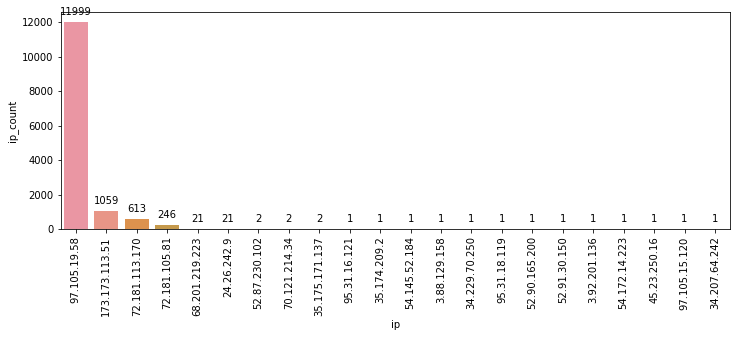

In [12]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

In [42]:
t = df.tz_convert(None)

In [44]:
train = t['2019-04-16':'2019-04-17'][['ip','request_method','status','size','destination','request_agent','size_mb']]


In [45]:
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

In [49]:
t = (t.reset_index()
     .merge(ip_df, on=['ip'], how='left')
     .fillna(value=0)
     .set_index('timestamp'))

In [51]:
t.ip_proba.value_counts()

0.858533    11999
0.075778     1059
0.043864      613
0.017603      246
0.001503       42
0.000072       11
0.000143        6
0.000000        2
Name: ip_proba, dtype: int64

In [53]:
ip_probs = train.groupby('ip').size().div(len(t))

status_given_ip = pd.DataFrame(train.groupby(['ip', 'status']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )

In [54]:
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_method'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'request_method': 'ip_status_count'}))


ip_status = status_given_ip.merge(ip_status_count)

In [55]:
t = (t.reset_index()
     .merge(ip_status, on=['ip', 'status'], how='left')
     .fillna(value=0)
     .set_index('timestamp'))


In [56]:
t.head()

,ip,request_method,status,size,destination,request_agent,size_mb,ip_proba_x,ip_proba_y,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.858533,0.858533,0.858533,0.999048,11984.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.858533,0.858533,0.858533,0.999048,11984.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.858533,0.858533,0.858533,0.999048,11984.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,0,python-requests/2.21.0,0.486377,0.858533,0.858533,0.858533,0.999048,11984.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,0,python-requests/2.21.0,0.488246,0.858533,0.858533,0.858533,0.999048,11984.0


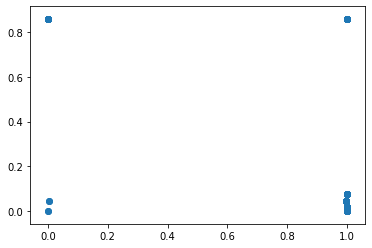

In [57]:
plt.scatter(t.proba_status_given_ip, t.ip_proba)


In [26]:
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

In [28]:
df.request_method.value_counts()

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1items HTTP/1.1                           2
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1              1
GET /api/v1/items/HTTP/1.1                          1
GET /api/V1/HiZach! HTTP/1.1                        1
GET /api/v1 HTTP/1.1        

In [32]:
mod = (pd.DataFrame(
    df.request_method.value_counts(dropna=False)).reset_index().
          rename(index=str, 
                 columns={'index': 'request_method', 'request_method': 'count'}))

In [33]:
mod

,request_method,count
0,GET /api/v1/sales HTTP/1.1,12403
1,GET /api/v1/items HTTP/1.1,1065
2,GET /api/v1/stores HTTP/1.1,229
3,GET / HTTP/1.1,107
4,GET /documentation HTTP/1.1,100
5,GET /favicon.ico HTTP/1.1,26
6,GET /api/v1//api/v1/items HTTP/1.1,11
7,GET /api/v1/items/api/v1/items HTTP/1.1,7
8,GET /api/v1/items/next_page HTTP/1.1,5
9,GET /api/v1/ HTTP/1.1,4


In [34]:
ip_df2 = (pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'}))

In [35]:
ip_df = ip_df.merge(ip_df2)

In [36]:
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,52.87.230.102,2,0.000143
7,70.121.214.34,2,0.000143
8,35.175.171.137,2,0.000143
9,95.31.16.121,1,0.000072
10,35.174.209.2,1,0.000072
11,54.145.52.184,1,0.000072
12,3.88.129.158,1,0.000072
13,34.229.70.250,1,0.000072
